# GAN_MNIST
This code below is all about Generative Adversarial Network (GAN Model) to generate images which are similar to MNIST datasets. It demonstrates GAN model code simulation.


## Import header

In [ ]:
import os
import torch
import torch.nn             as nn
import torch.optim          as optim
import torchvision
import torchvision.datasets as dsets
from   torch.utils.data       import DataLoader
from   torchvision.transforms import transforms
from   torchvision.utils      import save_image

## Select Cuda or CPU

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device: {}'.format(device))

device: cuda


## Give a seed

In [ ]:
torch.manual_seed(777)
if device=='cuda':
    torch.cuda.manual_seed_all(777)

## Hyper parameters

In [ ]:
image_size = 784 
hidden_size = 256
latent_code_size = 64
batch_size = 100 
total_epoch = 200
sample_dir= 'fake_images/1_Origin_Init/'

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## Dataset

In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                                     std=[0.5])
])
MNIST_train = dsets.MNIST(root = 'MNIST_data/', train=True,  transform=transform, download=True)
MNIST_test  = dsets.MNIST(root = 'MNIST_data/', train=False, transform=transform, download=True)

dataloader = DataLoader(dataset=MNIST_train, batch_size = batch_size, drop_last=True, shuffle=False)
iteration = len(dataloader)
print('iteration: {}'.format(iteration))

iteration: 600


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Model

In [ ]:
class Binary_Classfier_He(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(image_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size,1)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
        nn.init.kaiming_normal_(self.linear1.weight, a=0.2, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.linear2.weight, a=0.2, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.xavier_normal_(self.linear3.weight)

    def forward(self, x):
        out = self.linear1(x)
        out = self.LeakyReLU(out)
        
        out = self.linear2(out)
        out = self.LeakyReLU(out)

        out = self.linear3(out)
        out = self.sigmoid(out)
        return out

class GAN_He(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(latent_code_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size,image_size)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()
        nn.init.kaiming_normal_(self.linear1.weight, a=0.2, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.linear2.weight, a=0.2, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.xavier_normal_(self.linear3.weight)

    def forward(self,x):
        out = self.linear1(x)
        out = self.LeakyReLU(out)
        
        out = self.linear2(out)
        out = self.LeakyReLU(out)

        out = self.linear3(out)
        out = self.tanh(out)
        return out

BC_model_He = Binary_Classfier_He().to(device)
GAN_model_He = GAN_He().to(device)

In [ ]:
class Binary_Classfier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.LeakyReLU(0.2)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
        )
        self.layer3 = nn.Sequential(
            nn.Linear(hidden_size,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

class GAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(latent_code_size, hidden_size),
            nn.LeakyReLU(0.2)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
        )
        self.layer3 = nn.Sequential(
            nn.Linear(hidden_size, image_size),
            nn.Tanh()
        )
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

BC_model = Binary_Classfier().to(device)
GAN_model = GAN().to(device)

In [ ]:
criterion = nn.BCELoss().to(device)
BC_optimizer = optim.Adam(BC_model.parameters(), lr=0.0002)
GAN_optimizer = optim.Adam(GAN_model.parameters(), lr=0.0002)
BC_optimizer_He = optim.Adam(BC_model_He.parameters(), lr = 0.0002)
GAN_optimizer_He = optim.Adam(GAN_model_He.parameters(), lr=0.0002)

## Training

In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [ ]:
D_loss_array = list()
G_loss_array = list()

D_loss_array_He = list()
G_loss_array_He = list()

D_score_array = list()
G_score_array = list()

D_score_array_He = list()
G_score_array_He = list()

G_accuracy_array = list()
G_accuracy_array_He = list()

for epoch in range(total_epoch):
    D_average_loss = 0.
    G_average_loss = 0.

    D_average_loss_He = 0.
    G_average_loss_He = 0.

    G_average_score = 0.
    D_average_score = 0. 

    G_average_score_He = 0.
    D_average_score_He = 0. 

    G_average_accuracy = 0.
    G_average_accuracy_He = 0.

    for (images,_) in (dataloader):
        ### print(images.shape)
        images = images.reshape(batch_size, -1).to(device)
        ### print(images.shape)

        # Discriminator
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        ### print(real_labels.shape)
        ### print(fake_labels.shape)

        # Generator
        z = torch.randn(batch_size, latent_code_size).to(device)
        ### print('latent code z shape: {}'.format(z.shape))

        D_score = BC_model(images)
        D_score_He = BC_model_He(images)

        fake_images = GAN_model(z)
        G_score = BC_model(fake_images)
        fake_images_He = GAN_model_He(z)
        G_score_He = BC_model_He(fake_images_He)
        
        ### Discriminator loss and update parameters
        D_loss = criterion(D_score,real_labels) + criterion(G_score, fake_labels)
        BC_optimizer.zero_grad()
        GAN_optimizer.zero_grad()
        D_loss.backward(retain_graph=True)
        BC_optimizer.step()

        D_loss_He = criterion(D_score_He,real_labels) + criterion(G_score_He, fake_labels)
        BC_optimizer_He.zero_grad()
        GAN_optimizer_He.zero_grad()
        D_loss_He.backward(retain_graph=True)
        BC_optimizer_He.step()


        z = torch.randn(batch_size, latent_code_size).to(device)
        fake_images = GAN_model(z)
        G_score = BC_model(fake_images)
        fake_images_He = GAN_model_He(z)
        G_score_He = BC_model_He(fake_images_He)

        # Fix Discrimnator's parameters and update Generator's parameters only.
        # Update parameters of Generator.
        G_loss = criterion(G_score, real_labels)
        GAN_optimizer.zero_grad()
        BC_optimizer.zero_grad()
        G_loss.backward()
        GAN_optimizer.step()

        G_loss_He = criterion(G_score_He, real_labels)
        GAN_optimizer_He.zero_grad()
        BC_optimizer_He.zero_grad()
        G_loss_He.backward()
        GAN_optimizer_He.step()

        # Calculate average losse of Discriminator and Generator during one epoch.
        
        D_average_loss += D_loss/iteration
        G_average_loss += G_loss/iteration
        
        D_average_loss_He += D_loss_He/iteration
        G_average_loss_He += G_loss_He/iteration

        G_average_score += G_score.float().mean()/iteration
        D_average_score += D_score.float().mean()/iteration

        G_average_score_He += G_score_He.float().mean()/iteration
        D_average_score_He += D_score_He.float().mean()/iteration

        G_prediction = G_score >= 0.5
        G_accuracy = G_prediction.float().mean()
        G_average_accuracy += G_accuracy/iteration
    

        G_prediction_He = G_score_He >= 0.5
        G_accuracy_He = G_prediction_He.float().mean()
        G_average_accuracy_He += G_accuracy_He/iteration

    print('Epoch: {:4d}/{} D_Loss:    {:.5f} G_Loss:    {:.5f} D_score:    {:.5f} G_score:    {:.5f}, G_accuracy:     {:.5f}'.format(epoch, total_epoch, D_average_loss, G_average_loss, D_average_score.item(), G_average_score.item(), G_average_accuracy.item()))
    print('Epoch: {:4d}/{} D_Loss_He: {:.5f} G_Loss_He: {:.5f} D_score_He: {:.5f} G_score_He: {:.5f}, G_accuracy_He:  {:.5f}'.format(epoch, total_epoch, D_average_loss_He, G_average_loss_He, D_average_score_He.item(), G_average_score_He.item(), G_average_accuracy_He.item()))
    print('=====================================================================================================================')
    D_loss_array.append(D_average_loss.tolist())
    G_loss_array.append(G_average_loss.tolist())

    D_loss_array_He.append(D_average_loss_He.tolist())
    G_loss_array_He.append(G_average_loss_He.tolist())
   
    D_score_array.append(D_average_score.tolist()) 
    G_score_array.append(G_average_score.tolist())

    D_score_array_He.append(D_average_score_He.tolist()) 
    G_score_array_He.append(G_average_score_He.tolist()) 

    G_accuracy_array.append(G_average_accuracy.tolist()) 
    G_accuracy_array_He.append(G_average_accuracy_He.tolist()) 


    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    if ((epoch+1)%25==0 or epoch==0):
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images_Origin-{}.png'.format(epoch)))

        fake_images_He = fake_images_He.reshape(fake_images_He.size(0), 1, 28, 28)
        save_image(denorm(fake_images_He), os.path.join(sample_dir, 'fake_images_He-{}.png'.format(epoch)))

# Save the model checkpoints 
torch.save(GAN_model.state_dict(), 'GAN_model.ckpt')
torch.save(BC_model.state_dict(), 'BC_model.ckpt')
torch.save(GAN_model_He.state_dict(), 'GAN_model_He.ckpt')
torch.save(BC_model_He.state_dict(), 'BC_model_He.ckpt')


Epoch:    0/200 D_Loss:    0.48857 G_Loss:    2.84270 D_score:    0.88844 G_score:    0.14718, G_accuracy:     0.09748
Epoch:    0/200 D_Loss_He: 0.15762 G_Loss_He: 4.65212 D_score_He: 0.97904 G_score_He: 0.05328, G_accuracy_He:  0.03528
Epoch:    1/200 D_Loss:    0.38222 G_Loss:    3.43378 D_score:    0.88222 G_score:    0.06777, G_accuracy:     0.00942
Epoch:    1/200 D_Loss_He: 0.02577 G_Loss_He: 6.82680 D_score_He: 0.98964 G_score_He: 0.00392, G_accuracy_He:  0.00028
Epoch:    2/200 D_Loss:    0.67581 G_Loss:    2.87102 D_score:    0.80496 G_score:    0.10797, G_accuracy:     0.01748
Epoch:    2/200 D_Loss_He: 0.02891 G_Loss_He: 9.00940 D_score_He: 0.99082 G_score_He: 0.00650, G_accuracy_He:  0.00343
Epoch:    3/200 D_Loss:    0.72364 G_Loss:    2.39528 D_score:    0.79073 G_score:    0.14118, G_accuracy:     0.02930
Epoch:    3/200 D_Loss_He: 0.14724 G_Loss_He: 11.80558 D_score_He: 0.96374 G_score_He: 0.03760, G_accuracy_He:  0.03233
Epoch:    4/200 D_Loss:    0.55064 G_Loss:    2

## Download image file from Colab

In [ ]:
from google.colab import files

files.download('/content/fake_images/1_Origin_Init/fake_images_Origin-0.png')
files.download('/content/fake_images/1_Origin_Init/fake_images_Origin-24.png')
files.download('/content/fake_images/1_Origin_Init/fake_images_Origin-49.png')
files.download('/content/fake_images/1_Origin_Init/fake_images_Origin-74.png')
files.download('/content/fake_images/1_Origin_Init/fake_images_Origin-99.png')
files.download('/content/fake_images/1_Origin_Init/fake_images_Origin-124.png')
files.download('/content/fake_images/1_Origin_Init/fake_images_Origin-149.png')
files.download('/content/fake_images/1_Origin_Init/fake_images_Origin-174.png')
files.download('/content/fake_images/1_Origin_Init/fake_images_Origin-199.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/fake_images/1_Origin_Init/fake_images_He-0.png')
files.download('/content/fake_images/1_Origin_Init/fake_images_He-24.png')
files.download('/content/fake_images/1_Origin_Init/fake_images_He-49.png')
files.download('/content/fake_images/1_Origin_Init/fake_images_He-74.png')
files.download('/content/fake_images/1_Origin_Init/fake_images_He-99.png')
files.download('/content/fake_images/1_Origin_Init/fake_images_He-124.png')
files.download('/content/fake_images/1_Origin_Init/fake_images_He-149.png')
files.download('/content/fake_images/1_Origin_Init/fake_images_He-174.png')
files.download('/content/fake_images/1_Origin_Init/fake_images_He-199.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_compare(loss_list_origin: list, loss_list_he, ylim=None, title=None) -> None:
    plt.figure(figsize=(15, 10))
    plt.plot(loss_list_origin, label='origin')
    plt.plot(loss_list_he, label='He&Xavier')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

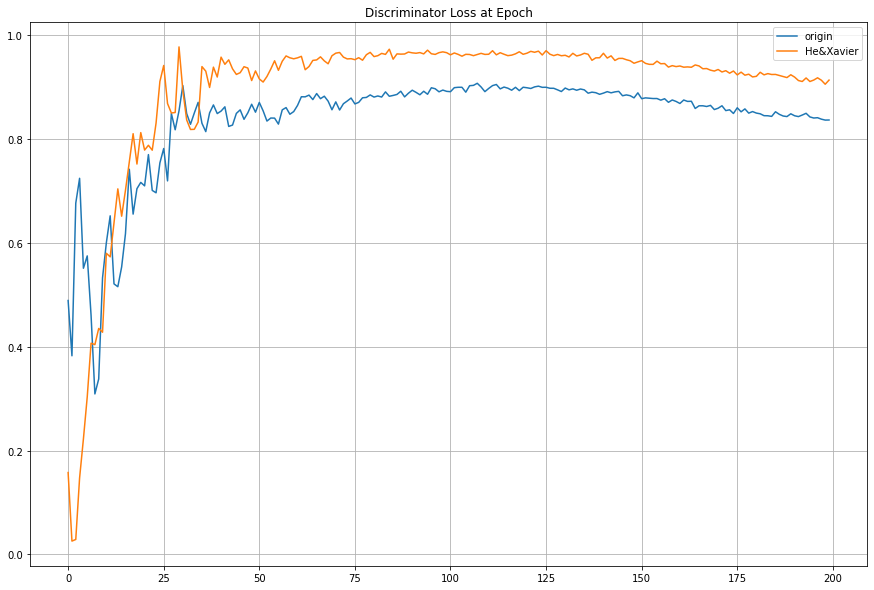

In [ ]:
plot_compare(D_loss_array,D_loss_array_He, title='Discriminator Loss at Epoch')

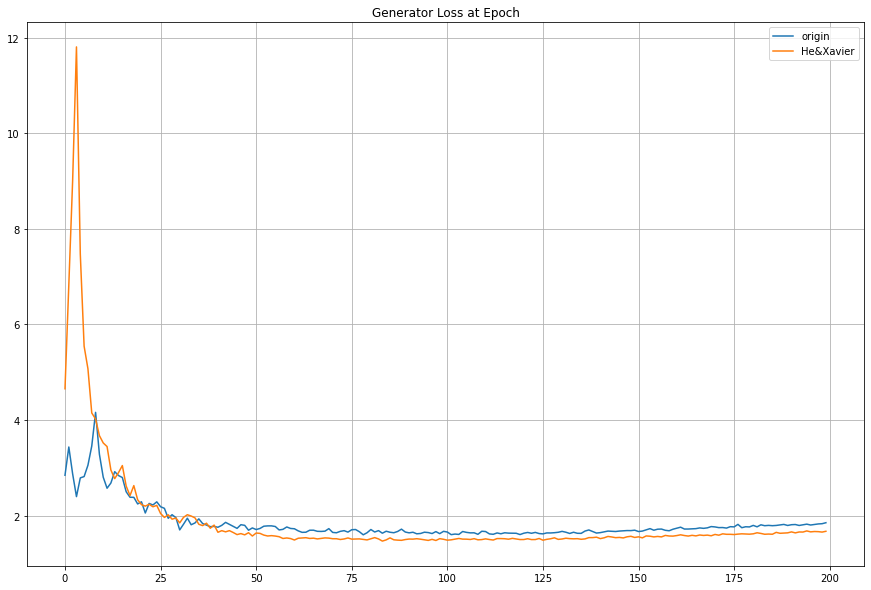

In [ ]:
plot_compare(G_loss_array,G_loss_array_He, title='Generator Loss at Epoch')

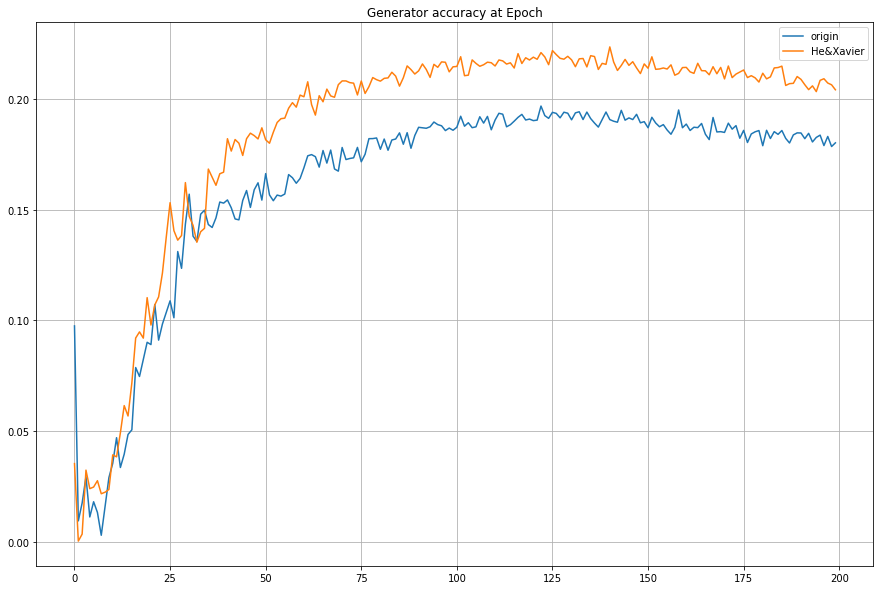

In [ ]:
plot_compare(G_accuracy_array,G_accuracy_array_He, title='Generator accuracy at Epoch')